In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:

ds_lr = xr.open_dataset('era5_2010_2020_daily.nc', engine='netcdf4')

print(f"Rango de fechas: {ds_lr.coords['time'][0].values} a {ds_lr.coords['time'][-1].values}")
print(f"Número total de muestras: {len(ds_lr.coords['time'])}")



Rango de fechas: 2010-01-01T00:00:00.000000000 a 2020-12-31T00:00:00.000000000
Número total de muestras: 4018


/tmp/ipykernel_382435/2197411301.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_lr = xr.open_dataset('era5_2010_2020_daily.nc', engine='netcdf4')


In [4]:
ds_hr = xr.open_dataset('tmean_cr2met_2010_2020.nc', engine='netcdf4')

print(f"Rango de fechas: {ds_hr.coords['time'][0].values} a {ds_hr.coords['time'][-1].values}")
print(f"Número total de muestras: {len(ds_hr.coords['time'])}")



Rango de fechas: 2010-01-01T00:00:00.000000000 a 2020-12-31T00:00:00.000000000
Número total de muestras: 4018


Recortar HR para que coincida con el rango de latitudes y longitudes de LR

In [5]:
ds_hr_adjusted = ds_hr.sel(
    lat=slice(-33.269, -32.768),
    lon=slice(-71.893, -70.142)
)

Obtener las variables de temperatura en LR y HR


In [6]:
lr_data = ds_lr['t2m'].values 
hr_data = ds_hr_adjusted['tmean'].values

lr_data = lr_data - 273.15  # Kelvin a Celsius

Estandarización de datos

Mínimo valor en X (antes de la estandarización): -22.385269165039062
Máximo valor en X (antes de la estandarización): 26.915802001953125
Mínimo valor en Y (antes de la estandarización): -16.66
Máximo valor en Y (antes de la estandarización): 26.975833333333338


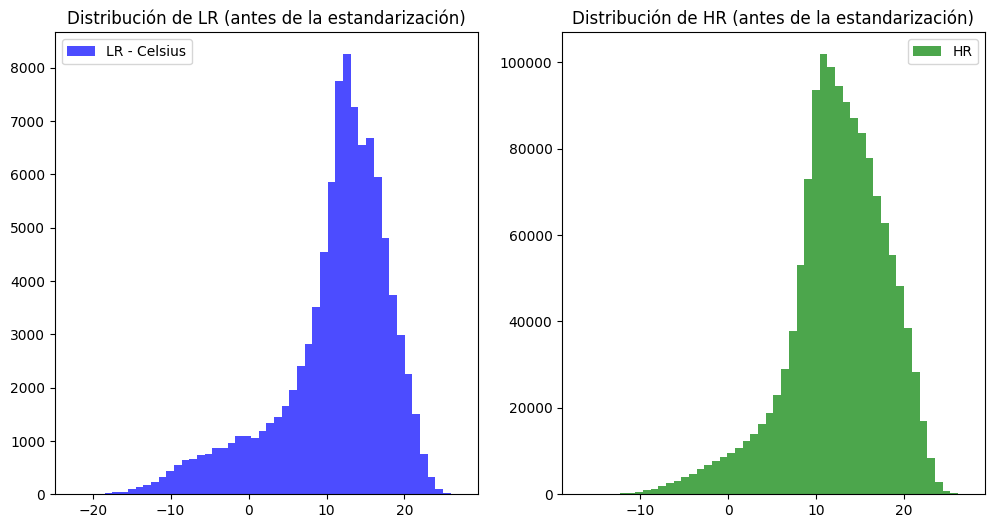

Mínimo valor en X (después de la estandarización): -4.646207809448242
Máximo valor en X (después de la estandarización): 2.208346128463745
Mínimo valor en Y (después de la estandarización): -5.21389595117011
Máximo valor en Y (después de la estandarización): 2.612399732629949


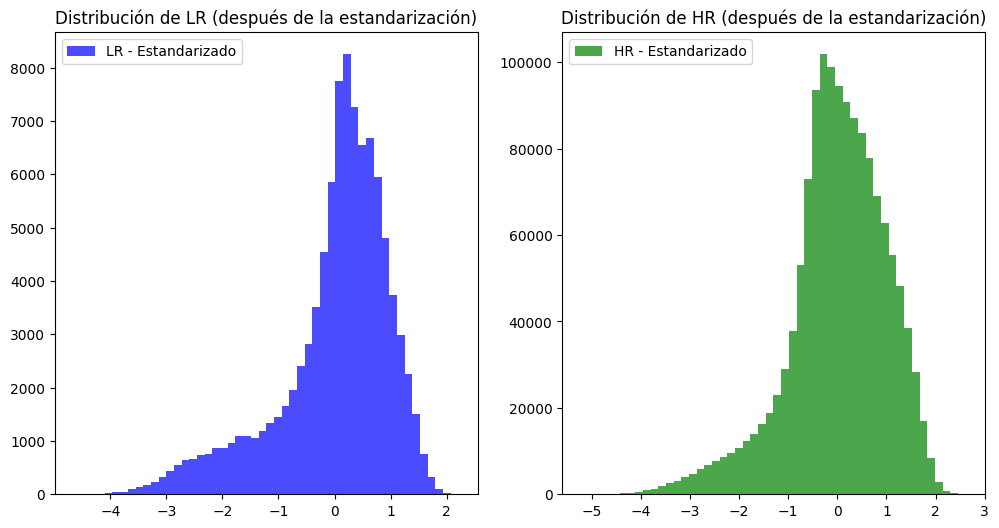

Forma de X (LR) después de la estandarización: (4018, 3, 8, 1)
Forma de Y (HR) después de la estandarización: (4018, 10, 35, 1)


In [7]:
print(f"Mínimo valor en X (antes de la estandarización): {np.min(lr_data)}")
print(f"Máximo valor en X (antes de la estandarización): {np.max(lr_data)}")
print(f"Mínimo valor en Y (antes de la estandarización): {np.min(hr_data)}")
print(f"Máximo valor en Y (antes de la estandarización): {np.max(hr_data)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(lr_data.flatten(), bins=50, color='blue', alpha=0.7, label='LR - Celsius')
plt.title('Distribución de LR (antes de la estandarización)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(hr_data.flatten(), bins=50, color='green', alpha=0.7, label='HR')
plt.title('Distribución de HR (antes de la estandarización)')
plt.legend()
plt.show()

X_mean = np.mean(lr_data)
X_std = np.std(lr_data)
Y_mean = np.mean(hr_data)
Y_std = np.std(hr_data)

X_standardized = (lr_data - X_mean) / X_std
Y_standardized = (hr_data - Y_mean) / Y_std

print(f"Mínimo valor en X (después de la estandarización): {np.min(X_standardized)}")
print(f"Máximo valor en X (después de la estandarización): {np.max(X_standardized)}")
print(f"Mínimo valor en Y (después de la estandarización): {np.min(Y_standardized)}")
print(f"Máximo valor en Y (después de la estandarización): {np.max(Y_standardized)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(X_standardized.flatten(), bins=50, color='blue', alpha=0.7, label='LR - Estandarizado')
plt.title('Distribución de LR (después de la estandarización)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(Y_standardized.flatten(), bins=50, color='green', alpha=0.7, label='HR - Estandarizado')
plt.title('Distribución de HR (después de la estandarización)')
plt.legend()
plt.show()

X = X_standardized.reshape(X_standardized.shape[0], X_standardized.shape[1], X_standardized.shape[2], 1)  # LR
Y = Y_standardized.reshape(Y_standardized.shape[0], Y_standardized.shape[1], Y_standardized.shape[2], 1)  # HR

print(f"Forma de X (LR) después de la estandarización: {X.shape}")
print(f"Forma de Y (HR) después de la estandarización: {Y.shape}")

Dividiendo los datos en test y entrenamiento

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")


Forma de X_train: (3214, 3, 8, 1)
Forma de X_test: (804, 3, 8, 1)
Forma de y_train: (3214, 10, 35, 1)
Forma de y_test: (804, 10, 35, 1)


Definición de funciones

In [9]:
# Función Lambda para imprimir las dimensiones intermedias
def print_shape(x):
    print(f"Shape de la capa {x.name}: {x.shape}") 
    return x


In [10]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    test_loss = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss}")
    return test_loss


In [11]:
# Function to plot training and validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [12]:
# Function to show examples and calculate the loss for each prediction
def show_examples(model, X_test, y_test):
    loss_function = tf.keras.losses.MeanSquaredError()

    y_pred = model.predict(X_test)

    plt.figure(figsize=(15, 10))

    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(X_test[i, :, :, 0], cmap='viridis')  # LR images
        plt.title(f"LR: {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+6)
        plt.imshow(y_test[i, :, :, 0], cmap='viridis')  # Ground truth (HR) images
        plt.title(f"Real: {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+11)
        plt.imshow(y_pred[i, :, :, 0], cmap='viridis')  # Predictions
        plt.title(f"Prediction: {i+1}")
        plt.axis('off')

        loss_value = loss_function(y_test[i:i+1], y_pred[i:i+1]).numpy()

        plt.text(1, 2, f'Loss: {loss_value:.4f}', color='white', fontsize=12)

    plt.tight_layout()
    plt.show()


Importaciones necesarias de tensorflow para hacer el modelo

In [13]:
from tensorflow.keras import layers, models, regularizers # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD # type: ignore


In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [15]:
model_1 = models.Sequential([
    layers.InputLayer(shape=(X_train.shape[1], X_train.shape[2], 1), name='Input_Layer'),
    
    # Capa convolucional con normalización por lotes
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_1'),
    layers.BatchNormalization(),  # Normalización de lotes


    # Aumento de resolución usando Conv2DTranspose (de 3x8 a 6x16)
    layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_1'),


    # Aumento de resolución usando Conv2DTranspose (de 6x16 a 12x32)
    layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_2'),


    # Capa de Dropout para evitar sobreajuste
    layers.Dropout(0.3),

    # Reducción de resolución para ajustar las dimensiones (de 12x32 a 12x32)
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_2'),


    # Otra capa de convolución para aprender más características (de 12x32 a 12x32)
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_3'),


    # Aumento de resolución usando UpSampling2D y Conv2D para refinar la resolución
    layers.UpSampling2D(size=(2, 3), interpolation='bilinear', name="UpSampling_Layer"),  # Ajuste de resolución
  # Imprime las dimensiones después de la capa de aumento de resolución

    # Capa final para generar la salida de alta resolución (HR)
    layers.Conv2D(1, (3, 3), activation='linear', padding='same', name='Conv2D_4'),


    # Cropping2D para recortar las dimensiones a 10x35
    layers.Cropping2D(cropping=((7, 7), (30, 31)), name="Cropping_Layer"),

])

I0000 00:00:1743003211.742258  382435 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 851 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [16]:
model_1.compile(optimizer=SGD(learning_rate=1e-6, momentum=0.9), loss='mean_squared_error')
model_1.summary()
history_1 = model_1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 3, 8, 64)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_1               │ (None, 6, 16, 128)     │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_2               │ (None, 12, 32, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 12, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 12, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ UpSampling_Layer (UpSampling2D) │ (None, 24, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 24, 96, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Cropping_Layer (Cropping2D)     │ (None, 10, 35, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,697 (3.10 MB)

 Trainable params: 813,569 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50


I0000 00:00:1743003216.074686  382605 service.cc:152] XLA service 0x7f7f9801e3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743003216.074700  382605 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-03-26 12:33:36.089912: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743003216.141820  382605 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-26 12:33:36.164856: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).
2025-03-26 12:33:36.572177: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.31GiB with freed_by_count=0. The caller 

 19/101 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9697

I0000 00:00:1743003218.434520  382605 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 98/101 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9896

2025-03-26 12:33:39.368988: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).
2025-03-26 12:33:39.527054: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-26 12:33:40.096176: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9896

2025-03-26 12:33:41.273054: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-26 12:33:41.783710: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.9896 - val_loss: 0.9712 - learning_rate: 1.0000e-06
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9897 - val_loss: 0.9691 - learning_rate: 1.0000e-06
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9864 - val_loss: 0.9661 - learning_rate: 1.0000e-06
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9754 - val_loss: 0.9618 - learning_rate: 1.0000e-06
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9727 - val_loss: 0.9564 - learning_rate: 1.0000e-06
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9903 - val_loss: 0.9504 - learning_rate: 1.0000e-06
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9845 - val_loss: 0.9454 - learning_rate: 1.0000e-06
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9850 - val_loss: 0.9417 - learning_rate: 1.0000e-06
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9768 - val_loss: 0.9387 - lea

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8639
Test loss: 0.8479567766189575


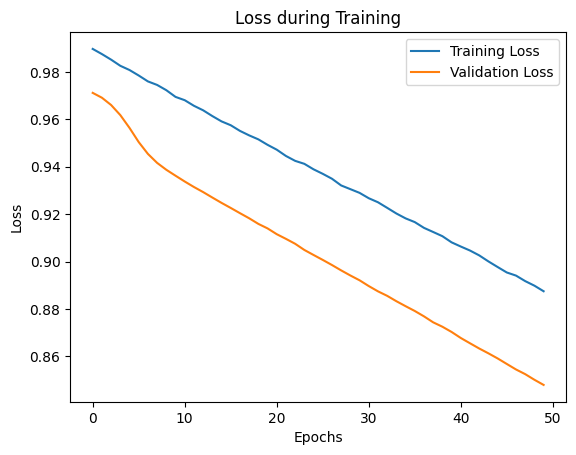

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


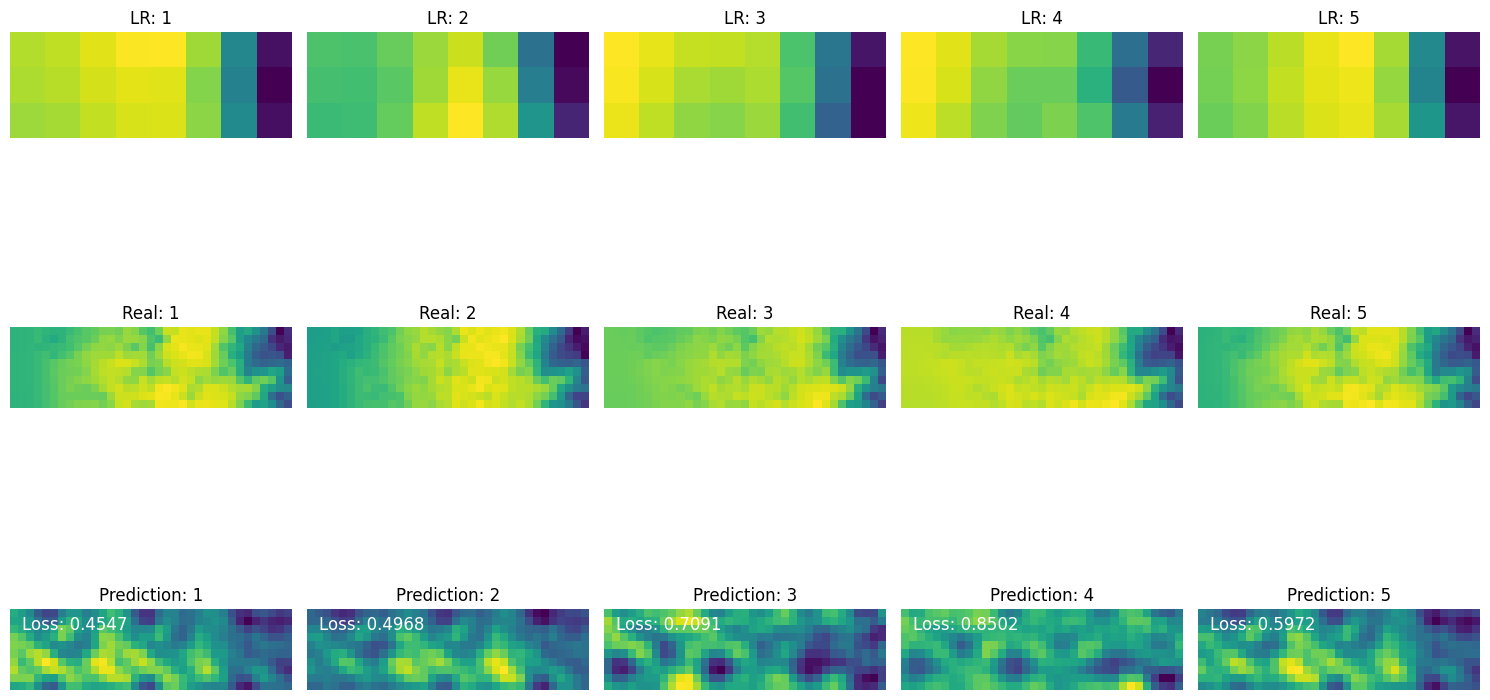

In [17]:
evaluate_model(model_1, X_test, y_test)
plot_loss(history_1)
show_examples(model_1, X_test, y_test)

Siguiente modelo con RSMprop y Regularización L2

In [18]:
# Reconstrucción del modelo con regularización L2 y optimizador RMSprop
model_2 = models.Sequential([
    layers.InputLayer(shape=(X_train.shape[1], X_train.shape[2], 1), name='Input_Layer'),
    
    # Capa convolucional con normalización por lotes y regularización L2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.01), name='Conv2D_1'),
    layers.BatchNormalization(),  # Normalización de lotes


    # Aumento de resolución usando Conv2DTranspose (de 3x8 a 6x16)
    layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_1'),


    # Aumento de resolución usando Conv2DTranspose (de 6x16 a 12x32)
    layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_2'),


    # Capa de Dropout para evitar sobreajuste
    layers.Dropout(0.5),

    # Reducción de resolución para ajustar las dimensiones
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_2'),


    # Otra capa de convolución para aprender más características
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_3'),


    # Aumento de resolución usando UpSampling2D y Conv2D para refinar la resolución
    layers.UpSampling2D(size=(2, 3), interpolation='bilinear', name="UpSampling_Layer"),  # Ajuste de resolución
  # Imprime las dimensiones después de la capa de aumento de resolución

    # Capa final para generar la salida de alta resolución (HR)
    layers.Conv2D(1, (3, 3), activation='linear', padding='same', name='Conv2D_4'),


    # Cropping2D para recortar las dimensiones a 10x35
    layers.Cropping2D(cropping=((7, 7), (30, 31)), name="Cropping_Layer"),

])

In [19]:
optimizer = RMSprop(learning_rate=1e-4)
model_2.compile(optimizer=optimizer, loss='mean_squared_error')
model_2.summary()
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 3, 8, 64)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_1               │ (None, 6, 16, 128)     │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_2               │ (None, 12, 32, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 12, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 12, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ UpSampling_Layer (UpSampling2D) │ (None, 24, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 24, 96, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Cropping_Layer (Cropping2D)     │ (None, 10, 35, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,697 (3.10 MB)

 Trainable params: 813,569 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50


2025-03-26 12:34:56.581835: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


 97/101 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3218

2025-03-26 12:34:58.433904: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3155 - val_loss: 0.7319 - learning_rate: 1.0000e-04
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1212 - val_loss: 0.6442 - learning_rate: 1.0000e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1022 - val_loss: 0.5422 - learning_rate: 1.0000e-04
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0893 - val_loss: 0.3772 - learning_rate: 1.0000e-04
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0814 - val_loss: 0.1884 - learning_rate: 1.0000e-04
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0765 - val_loss: 0.1221 - learning_rate: 1.0000e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0729 - val_loss: 0.0874 - learning_rate: 1.0000e-04
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0709 - val_loss: 0.0614 - learning_rate: 1.0000e-04
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0652 - val_loss: 0.0599 - le

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0340
Test loss: 0.03386881202459335


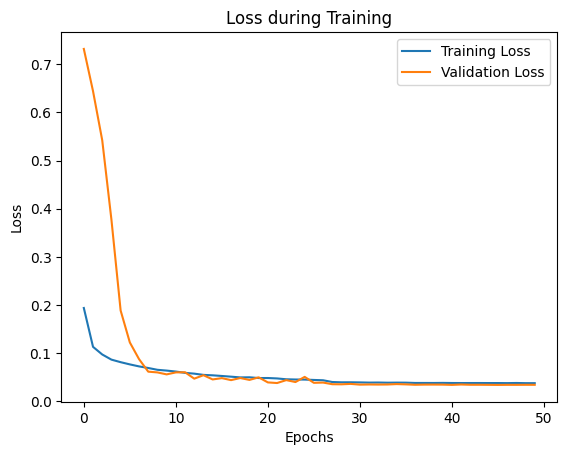

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


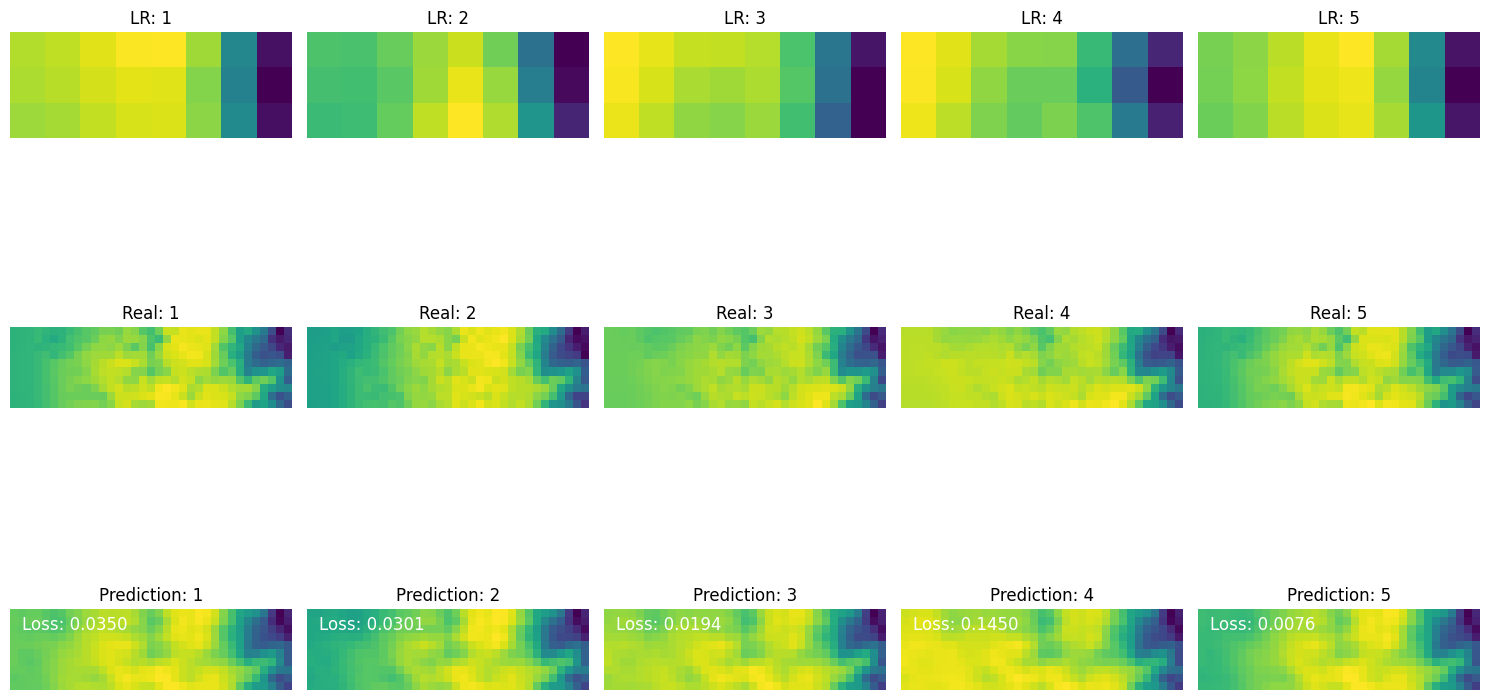

In [20]:
evaluate_model(model_2, X_test, y_test)
plot_loss(history_2)
show_examples(model_2, X_test, y_test)

Modelo con UpSampling2D ajustado

In [21]:
# Reconstrucción del modelo con UpSampling2D ajustado
model_3 = models.Sequential([
    layers.InputLayer(shape=(X_train.shape[1], X_train.shape[2], 1), name='Input_Layer'),
    
    # Capa convolucional con normalización por lotes
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_1'),
    layers.BatchNormalization(),  # Normalización de lotes


    # Aumento de resolución usando Conv2DTranspose (de 3x8 a 6x16)
    layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_1'),


    # Aumento de resolución usando Conv2DTranspose (de 6x16 a 12x32)
    layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_2'),


    # Capa de Dropout para evitar sobreajuste
    layers.Dropout(0.5),

    # Reducción de resolución para ajustar las dimensiones
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_2'),


    # Otra capa de convolución para aprender más características
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_3'),


    # Aumento de resolución usando UpSampling2D con escala (2, 2)
    layers.UpSampling2D(size=(2, 2), interpolation='bilinear', name="UpSampling_Layer"),  # Ajuste de resolución uniforme
  # Imprime las dimensiones después de la capa de aumento de resolución

    # Capa final para generar la salida de alta resolución (HR)
    layers.Conv2D(1, (3, 3), activation='linear', padding='same', name='Conv2D_4'),


    # Cropping2D para recortar las dimensiones a 10x35
    layers.Cropping2D(cropping=((7, 7), (25, 4)), name="Cropping_Layer"),

])


In [22]:
model_3.compile(optimizer='adam', loss='mean_squared_error')
model_3.summary()
history_3 = model_3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 3, 8, 64)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_1               │ (None, 6, 16, 128)     │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_2               │ (None, 12, 32, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 12, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 12, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ UpSampling_Layer (UpSampling2D) │ (None, 24, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 24, 64, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Cropping_Layer (Cropping2D)     │ (None, 10, 35, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,697 (3.10 MB)

 Trainable params: 813,569 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50


2025-03-26 12:36:07.108821: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


 96/101 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2125

2025-03-26 12:36:09.043241: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-6), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2060 - val_loss: 0.7380 - learning_rate: 0.0010
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0437 - val_loss: 0.6493 - learning_rate: 0.0010
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0428 - val_loss: 0.5658 - learning_rate: 0.0010
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0373 - val_loss: 0.3044 - learning_rate: 0.0010
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0322 - val_loss: 0.1350 - learning_rate: 0.0010
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0389 - val_loss: 0.0723 - learning_rate: 0.0010
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0346 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0285 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0310 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 10/50
101/101 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149
Test loss: 0.01467128936201334


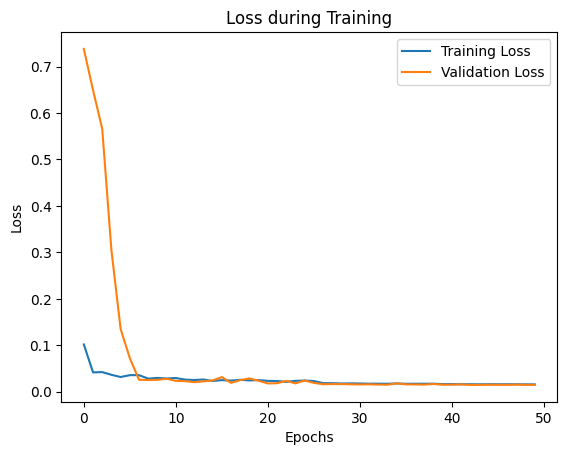

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


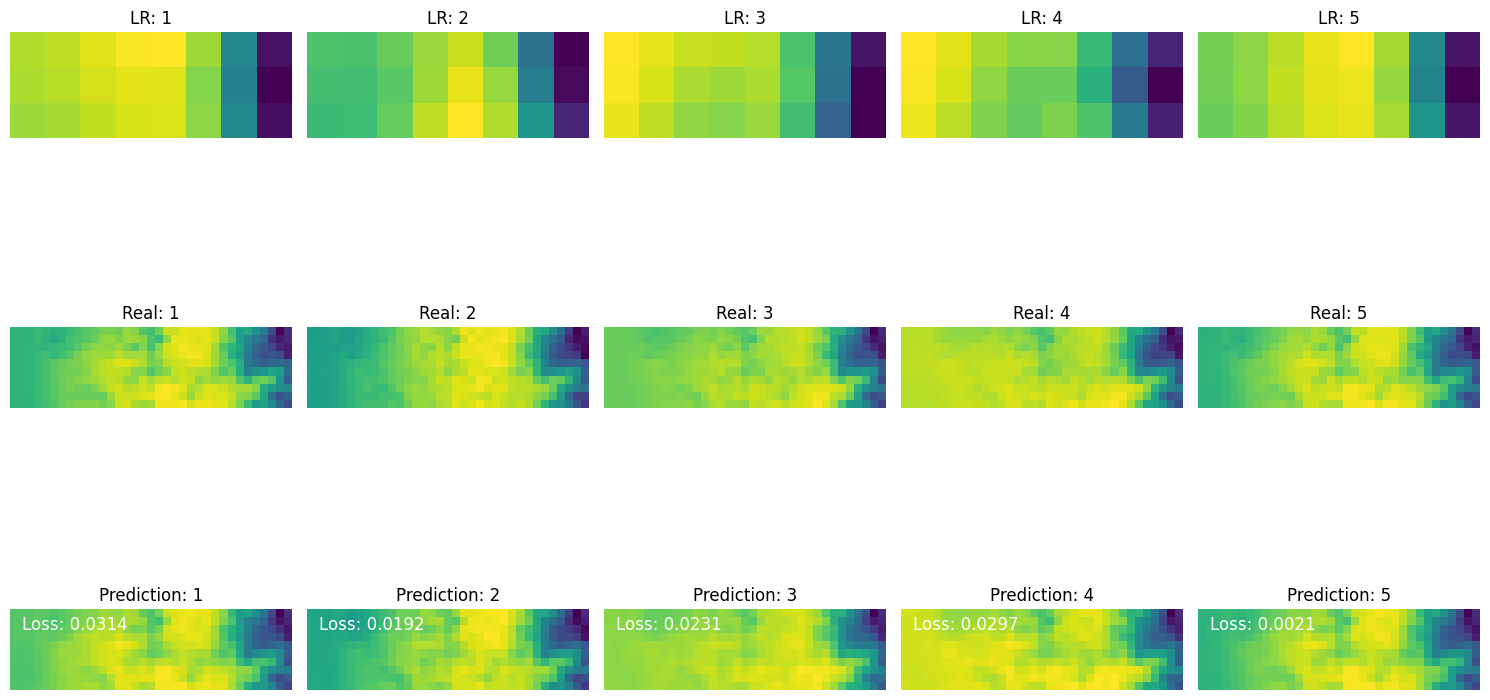

In [23]:
evaluate_model(model_3, X_test, y_test)
plot_loss(history_3)
show_examples(model_3, X_test, y_test)

Reconstrucción del modelo con regularización L2


In [24]:
model_4 = models.Sequential([
    layers.InputLayer(shape=(X_train.shape[1], X_train.shape[2], 1), name='Input_Layer'),
    
    # Capa convolucional con normalización por lotes y regularización L2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.01), name='Conv2D_1'),  # L2 regularization
    layers.BatchNormalization(),  # Normalización de lotes


    # Aumento de resolución usando Conv2DTranspose (de 3x8 a 6x16)
    layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', 
                           kernel_regularizer=regularizers.l2(0.01), name='Conv2DTranspose_1'),


    # Aumento de resolución usando Conv2DTranspose (de 6x16 a 12x32)
    layers.Conv2DTranspose(256, (3, 3), strides=(2, 3), padding='same', 
                           kernel_regularizer=regularizers.l2(0.01), name='Conv2DTranspose_2'),


    # Capa de Dropout para evitar sobreajuste
    layers.Dropout(0.3),

    # Reducción de resolución para ajustar las dimensiones
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.01), name='Conv2D_2'),


    # Otra capa de convolución para aprender más características
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.01), name='Conv2D_3'),


    # Capa final para generar la salida de alta resolución (HR)
    layers.Conv2D(1, (3, 3), activation='linear', padding='same', name='Conv2D_4'),


    # Cropping2D para recortar las dimensiones a 10x35
    layers.Cropping2D(cropping=((1, 1), (6, 7)), name="Cropping_Layer"),

])


In [25]:
model_4.compile(optimizer='adam', loss='mean_squared_error')
model_4.summary()
history_4 = model_4.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 3, 8, 64)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_1               │ (None, 6, 16, 128)     │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2DTranspose_2               │ (None, 12, 48, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 48, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 12, 48, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 12, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (None, 12, 48, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Cropping_Layer (Cropping2D)     │ (None, 10, 35, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,697 (3.10 MB)

 Trainable params: 813,569 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50


2025-03-26 12:37:05.321333: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).
2025-03-26 12:37:05.539173: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-26 12:37:05.595600: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 676.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-26 12:37:06.130118: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory

100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2375

2025-03-26 12:37:07.742324: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).
2025-03-26 12:37:07.895530: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 3.2082 - val_loss: 1.0625 - learning_rate: 0.0010
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3092 - val_loss: 0.7844 - learning_rate: 0.0010
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1682 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1347 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1234 - val_loss: 0.3201 - learning_rate: 0.0010
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1167 - val_loss: 0.1476 - learning_rate: 0.0010
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1010 - val_loss: 0.1559 - learning_rate: 0.0010
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1058 - val_loss: 0.1078 - learning_rate: 0.0010
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1106 - val_loss: 0.0867 - learning_rate: 0.0010
Epoch 10/50
101/101 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0635 
Test loss: 0.06289783865213394


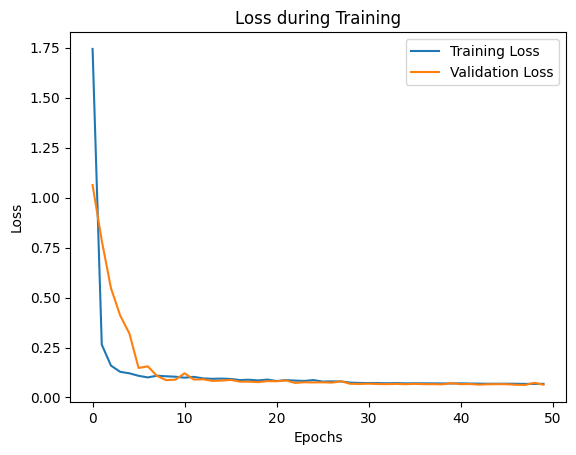

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


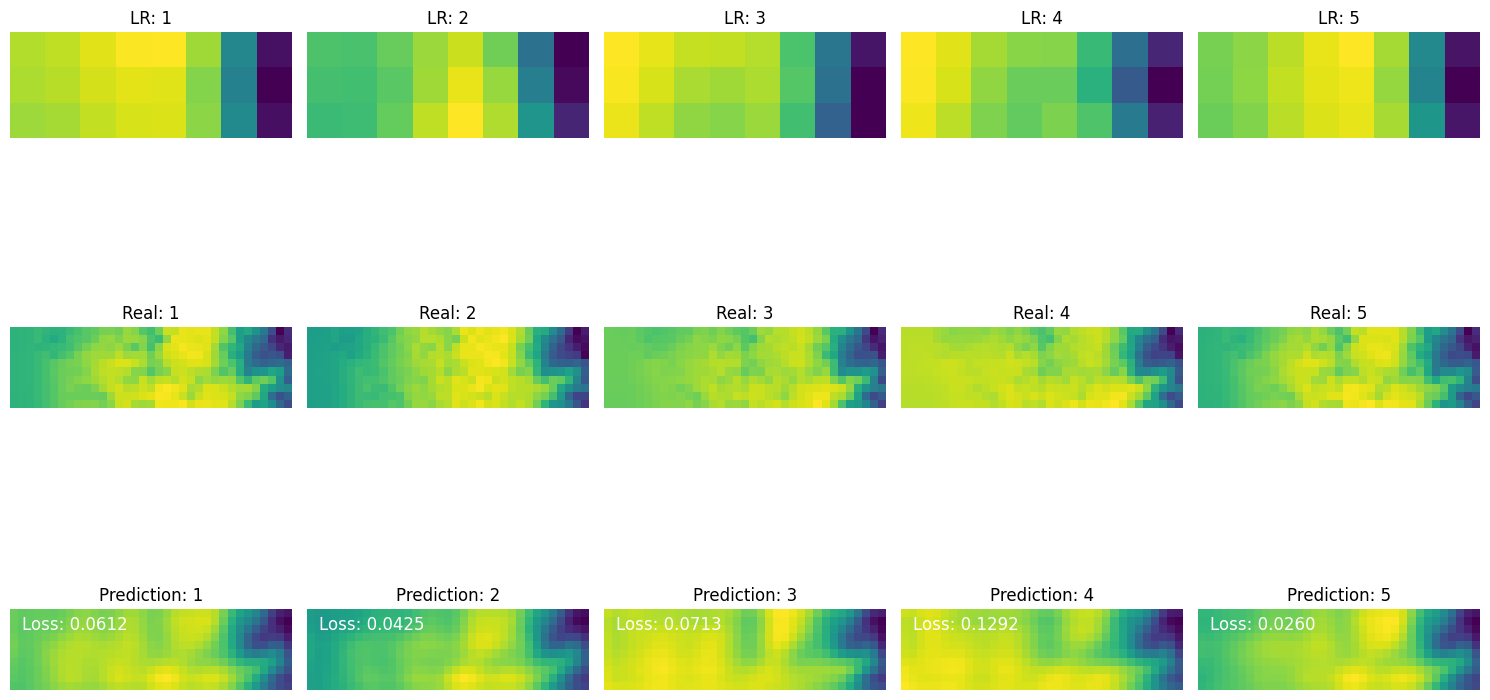

In [26]:
evaluate_model(model_4, X_test, y_test)
plot_loss(history_4)
show_examples(model_4, X_test, y_test)

In [27]:
model_4.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')
history_5 = model_4.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2025-03-26 12:37:51.116015: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


 99/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0963

2025-03-26 12:37:52.649409: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0959 - val_loss: 0.0719 - learning_rate: 0.0010
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0772 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0705 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0716 - val_loss: 0.0635 - learning_rate: 0.0010
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0723 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1062 - val_loss: 1.4731 - learning_rate: 0.0010
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4984 - val_loss: 0.2002 - learning_rate: 0.0010
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1975 - val_loss: 0.1404 - learning_rate: 0.0010
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1451 - val_loss: 0.1275 - learning_rate: 0.0010
Epoch 10/100

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0641 
Test loss: 0.0635332390666008


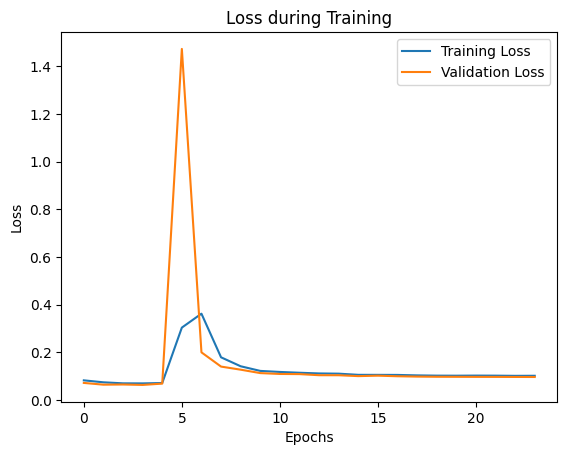

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


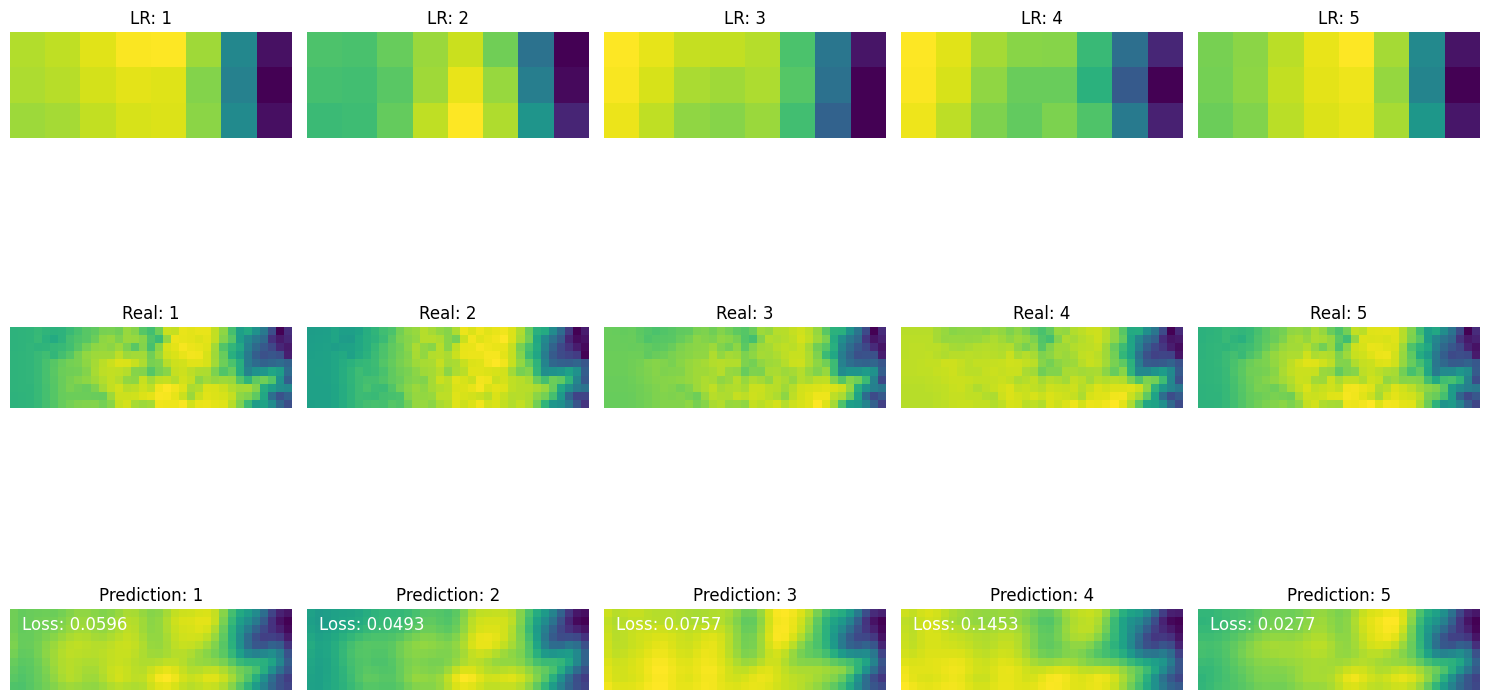

In [28]:
evaluate_model(model_4, X_test, y_test)
plot_loss(history_5)
show_examples(model_4, X_test, y_test)

In [29]:
model_4.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mean_squared_error')
history_6 = model_4.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2025-03-26 14:34:37.085354: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0677

2025-03-26 14:34:38.556242: W external/local_xla/xla/service/gpu/transforms/conv_rewriter.cc:467] The low padding of the backward convolution would be negative (-5), which isn't supported by GpuConvPaddingLegalization for now (b/32744257).


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0677 - val_loss: 0.0618 - learning_rate: 1.0000e-04
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0661 - val_loss: 0.0655 - learning_rate: 1.0000e-04
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0668 - val_loss: 0.0636 - learning_rate: 1.0000e-04
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0668 - val_loss: 0.0644 - learning_rate: 1.0000e-04
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0658 - val_loss: 0.0679 - learning_rate: 1.0000e-04
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0664 - val_loss: 0.0612 - learning_rate: 1.0000e-04
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0652 - val_loss: 0.0632 - learning_rate: 1.0000e-04
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0655 - val_loss: 0.0613 - learning_rate: 1.0000e-04
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0654 - val_loss: 0.0618 - le

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0581
Test loss: 0.05759010836482048


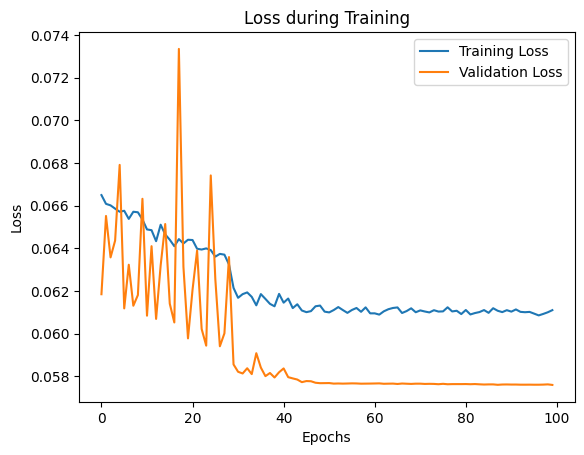

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


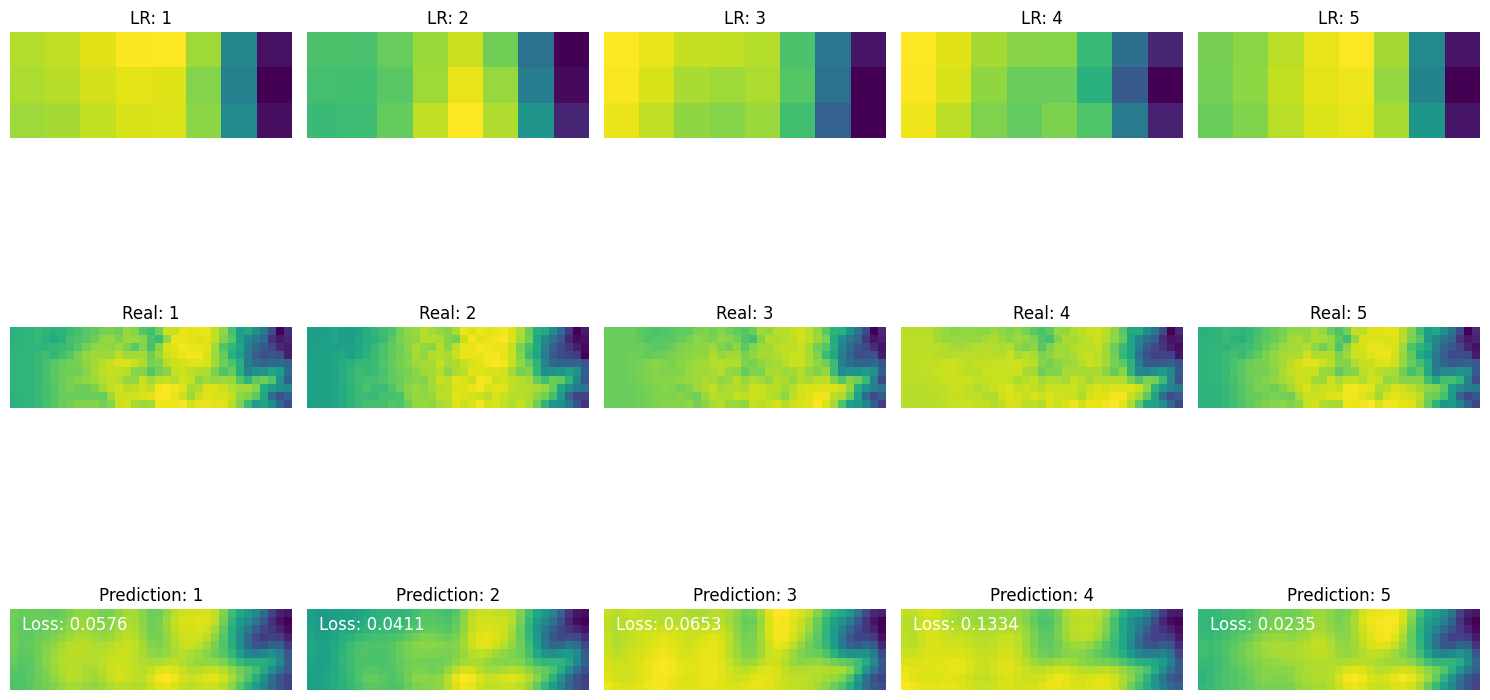

In [30]:
evaluate_model(model_4, X_test, y_test)
plot_loss(history_6)
show_examples(model_4, X_test, y_test)